In [1]:
# 3. Policy-based methods with deep neural network [30 points]
# Implement REINFORCE and Actor-Critic method for both the Acrobot-v1 and ALE/Assault-ram-v5 environments.
# π(ai|s) = (exp(z(s, ai)/T) / Σa∈A exp(z(s, a)/T))
# • Implement a Boltzman’s Policy as in eq. (3) and Neural Network approximation for z. That is z(s) = M LP (s, θ), where θ are the parameters of z you need to learn, and a ∈ {1, . . . , m} is a discrete action. In the case of the Actor-Critic algorithm use a Neural Network approximation for the State-Value function ˆV (s, w), where w are the parameters of the State-Value function.
# • Similar to Question-1, use appropriate initialization & model configuration for the policy parameters and state-value parameters.
# • Implement a Boltzman’s Policy and run 50 learning trials with different initializations for the model, each having 1000 episodes for the following two configurations. 1. A fixed temperature T > 0 (of your choice) and 2. A decreasing temperature T . (50 runs * 1000 episodes * 2 configuration) You are free to choose your step sizes for these implementations.
# • Plot training curves with the mean across seeds as lines and the standard deviation as a shaded region. (Performance on the Y-axis, and the episode on the X-axis). Generate 2 graphs covering all configurations per environment. Use green for REINFORCE and red for Actor-Critic, differentiating hyperparameters with different line styles (e.g., solid, dashed).
# • Similar to value-based methods, you can implement all the methods using any automatic differentiation package, such as Pytorch.

In [2]:
# env_name = 'Acrobot-v1'
env_name = 'ALE/Assault-ram-v5'

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import random
import os
import time
from torch.distributions import Categorical
from torch.nn import functional as F
import pickle

# Hyperparameters
EPISODES = 1000
MAX_STEPS = 1000
GAMMA = 0.99
HIDDEN_DIM = 256
SEEDS = 10

# Environment
env = gym.make(env_name)
env._max_episode_steps = MAX_STEPS

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Neural Network
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, HIDDEN_DIM)
        self.fc2 = nn.Linear(HIDDEN_DIM, action_dim)

        # Initialize parameters
        for m in self.modules():
            if isinstance(m, nn.Linear):
                print("initializing layer", m)
                nn.init.uniform_(m.weight, -0.01, 0.01)
                nn.init.uniform_(m.bias, -0.01, 0.01)

    def forward(self, x):
        x = x / 255.0
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ValueNetwork(nn.Module):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, HIDDEN_DIM)
        self.fc2 = nn.Linear(HIDDEN_DIM, 1)
        
        # Initialize parameters
        for m in self.modules():
            if isinstance(m, nn.Linear):
                print("initializing layer", m)
                nn.init.uniform_(m.weight, -0.01, 0.01)
                nn.init.uniform_(m.bias, -0.01, 0.01)

    def forward(self, x):
        x = x / 255.0
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def reinforce(lr, temperature, final_temperature, seeds):
    policy_network = PolicyNetwork().to(device)
    optimizer_policy = optim.Adam(policy_network.parameters(), lr=lr)
    rewards = []
    initial_temperature = temperature
    for episode in range(EPISODES):
        rewards_episode = []
        log_probs = []
        values = []
        state, info = env.reset()
        done = False
        temperature = initial_temperature - (initial_temperature - final_temperature) * episode / EPISODES
        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            logits = policy_network(state_tensor)
            probs = F.softmax(logits / temperature, dim=1)
            m = Categorical(probs)
            action = m.sample().item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            rewards_episode.append(reward)
            log_probs.append(m.log_prob(torch.tensor(action).to(device)))
            state = next_state
        rewards.append(sum(rewards_episode))
        returns = []
        R = 0
        for r in rewards_episode[::-1]:
            R = r + GAMMA * R
            returns.insert(0, R)
        returns = torch.tensor(returns).to(device)
        log_probs = torch.stack(log_probs)
        policy_loss = -log_probs * returns
        optimizer_policy.zero_grad()
        policy_loss.sum().backward()
        optimizer_policy.step()

        if episode % 10 == 0:
            print(episode, sum(rewards_episode), policy_loss.sum().item())
    return rewards

def actor_critic(lr, temperature, final_temperature, seeds):
    policy_network = PolicyNetwork().to(device)
    value_network = ValueNetwork().to(device)
    optimizer_policy = optim.Adam(policy_network.parameters(), lr=lr)
    optimizer_value = optim.Adam(value_network.parameters(), lr=lr)
    rewards = []
    initial_temperature = temperature
    for episode in range(EPISODES):
        rewards_episode = []
        log_probs = []
        values = []
        state, info = env.reset()
        done = False
        temperature = initial_temperature - (initial_temperature - final_temperature) * episode / EPISODES
        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            logits = policy_network(state_tensor)
            probs = F.softmax(logits / temperature, dim=1)
            m = Categorical(probs)
            action = m.sample().item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            rewards_episode.append(reward)
            log_probs.append(m.log_prob(torch.tensor(action).to(device)))
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            value = value_network(state_tensor)
            values.append(value)
            state = next_state
        rewards.append(sum(rewards_episode))
        returns = []
        R = 0
        for r in rewards_episode[::-1]:
            R = r + GAMMA * R
            returns.insert(0, R)
        returns = torch.tensor(returns).to(device)
        log_probs = torch.stack(log_probs)
        values = torch.stack(values).squeeze()
        advantages = returns - values
        policy_loss = -log_probs * advantages
        value_loss = F.mse_loss(values, returns)
        optimizer_policy.zero_grad()
        optimizer_value.zero_grad()
        policy_loss.sum().backward(retain_graph=True)
        value_loss.backward()
        optimizer_policy.step()
        optimizer_value.step()

        if episode % 10 == 0:
            print(episode, sum(rewards_episode), policy_loss.sum().item(), value_loss.item())
    return rewards

def run_experiment(lr, temperature, final_temperature, seeds):
    if temperature < final_temperature:
        return
    random_seeds = [0, 1, 2, 3, 4, 5, 6, 8, 11, 12]
    print(seeds)
    reinforce_rewards = np.zeros((seeds, EPISODES))
    actor_critic_rewards = np.zeros((seeds, EPISODES))
    if os.path.exists(f'reinforce_rewards_{lr}_{temperature}_{final_temperature}.pkl'):
        old_reinforce_rewards = pickle.load(open(f'reinforce_rewards_{lr}_{temperature}_{final_temperature}.pkl', 'rb'))
        reinforce_rewards[:min(old_reinforce_rewards.shape[0], seeds)] = old_reinforce_rewards[:min(old_reinforce_rewards.shape[0], seeds)]
    if os.path.exists(f'actor_critic_rewards_{lr}_{temperature}_{final_temperature}.pkl'):
        old_actor_critic_rewards = pickle.load(open(f'actor_critic_rewards_{lr}_{temperature}_{final_temperature}.pkl', 'rb'))
        actor_critic_rewards[:min(old_actor_critic_rewards.shape[0], seeds)] = old_actor_critic_rewards[:min(old_actor_critic_rewards.shape[0], seeds)]
    # for i, seed in enumerate(random_seeds):
    for i in range(seeds):
        print(f'Run {i+1}/{seeds}')
        if reinforce_rewards[i].sum() == 0:
            print('REINFORCE')
            reinforce_rewards[i] = reinforce(lr, temperature, final_temperature, seeds)
            pickle.dump(reinforce_rewards, open(f'reinforce_rewards_{lr}_{temperature}_{final_temperature}.pkl', 'wb'))
        if actor_critic_rewards[i].sum() == 0:
            print('Actor-Critic')
            actor_critic_rewards[i] = actor_critic(lr, temperature, final_temperature, seeds)
            pickle.dump(actor_critic_rewards, open(f'actor_critic_rewards_{lr}_{temperature}_{final_temperature}.pkl', 'wb'))
        reinforce_rewards_mean = reinforce_rewards[:i+1].mean(axis=0)
        reinforce_rewards_std = reinforce_rewards[:i+1].std(axis=0)
        actor_critic_rewards_mean = actor_critic_rewards[:i+1].mean(axis=0)
        actor_critic_rewards_std = actor_critic_rewards[:i+1].std(axis=0)
        plt.plot(reinforce_rewards_mean, label='REINFORCE', color='green')
        plt.fill_between(range(EPISODES), reinforce_rewards_mean - reinforce_rewards_std, reinforce_rewards_mean + reinforce_rewards_std, color='green', alpha=0.2)
        plt.plot(actor_critic_rewards_mean, label='Actor-Critic', color='red')
        plt.fill_between(range(EPISODES), actor_critic_rewards_mean - actor_critic_rewards_std, actor_critic_rewards_mean + actor_critic_rewards_std, color='red', alpha=0.2)
        plt.title(f'lr={lr}, temperature={temperature}, final_temperature={final_temperature}')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.savefig(f'plot_{i}_{lr}_{temperature}_{final_temperature}.png')
        plt.show()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/Users/jonathanlamontange-kratz/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


0.001 1 0.1
1
Run 1/1
Actor-Critic
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=1, bias=True)


/Users/jonathanlamontange-kratz/Library/Python/3.9/lib/python/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0 189.0 16638612.0 1391.7650146484375
10 378.0 42274576.0 2813.968505859375
20 63.0 2314664.5 177.0738983154297
30 378.0 39924752.0 2696.275634765625
40 189.0 8664604.0 584.5912475585938
50 168.0 6780085.5 456.6822204589844
60 315.0 14049269.0 497.9964599609375
70 252.0 3087842.25 657.2041625976562
80 294.0 -8739876.0 701.4476318359375
90 189.0 -5266066.0 1309.5833740234375
100 399.0 -25399068.0 1022.8318481445312
110 399.0 -37135480.0 2948.94677734375
120 168.0 -34449896.0 8739.462890625
130 210.0 -85206984.0 15485.1083984375
140 252.0 -74298096.0 17255.0
150 273.0 -97800432.0 24795.53125
160 294.0 -108156432.0 36150.60546875
170 315.0 -135263760.0 47293.8203125
180 210.0 -104079616.0 71007.0078125
190 315.0 -226109808.0 82673.1015625
200 357.0 -320704352.0 113154.8046875
210 210.0 -300719520.0 151374.78125
220 105.0 -166849456.0 200733.703125
230 189.0 -236246896.0 232930.90625
240 357.0 -401125728.0 270650.75
250 189.0 -238647776.0 352591.15625
260 168.0 -396858464.0 427371.5
270 23

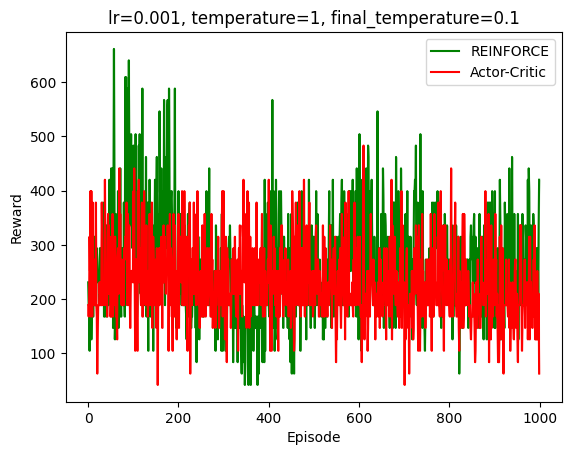

0.001 1 1
1
Run 1/1
REINFORCE
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 231.0 26919144.0
10 357.0 50737140.0
20 294.0 27671294.0
30 252.0 20113158.0
40 42.0 744563.375
50 399.0 42085668.0
60 231.0 15630552.0
70 252.0 26046140.0
80 378.0 39671584.0
90 462.0 57966516.0
100 294.0 25530404.0
110 294.0 30653026.0
120 189.0 8336816.5
130 315.0 23663540.0
140 483.0 35100824.0
150 315.0 17940714.0
160 315.0 25040058.0
170 210.0 9908672.0
180 231.0 11911526.0
190 273.0 21602964.0
200 336.0 26809646.0
210 252.0 21952810.0
220 294.0 27990514.0
230 126.0 6247086.0
240 483.0 66675416.0
250 315.0 25449388.0
260 252.0 19075444.0
270 189.0 20119890.0
280 273.0 32291708.0
290 357.0 44093228.0
300 231.0 15407967.0
310 231.0 22509386.0
320 210.0 17571890.0
330 252.0 20696958.0
340 315.0 31065204.0
350 357.0 43531308.0
360 252.0 22715416.0
370 294.0 23455638.0
380 210.0 17828214.0
390 294.0 31825732.0
400

KeyboardInterrupt: 

In [ ]:
initial_temperatures = [0.01, 0.1, 1, 10]
final_temperatures = [0.01, 0.1, 1, 10]
lrs = [0.0001, 0.001, 0.01, 0.1] 

for i in range(1, 11):
    for lr in lrs:
        for initial_temperature in initial_temperatures:
            for final_temperature in final_temperatures:
                print(lr, initial_temperature, final_temperature)
                run_experiment(lr, initial_temperature, final_temperature, i)
    